# [Multilevel Modeling](https://en.wikipedia.org/wiki/Multilevel_model)
Idea: Decompose the sum of random numbers into its contributions

for a given set of $x_i$ and $a_{ik}$ with
$$x_i = \Sigma_{j=0}^n \Sigma_{k=1}^{m_j} a_{ik}y_{jk}$$ 
with
* $m_j$ being the number of contributers of layer j
* $y_{jk}$ being the k-th contribution of layer j
* $m_0 = 1$ by default
* $a_{ik} \in \{0, 1\}$
* $\Sigma a_{ik} = 1$ only one contributer per layer

calculate the Distributions $y_{k} \sim N(μ_{k}, σ_{k})$
Boundary conditions:
* $\Sigma _{k} μ_k = 0$ via $μ_{m_j} = -\Sigma_{k = 1}^{m_j-1} μ_{k}$

In [1]:
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import logging
import seaborn as sns
import pymc as pm
import arviz as az
import bambi as bmb
import pandas as pd
import pymc.sampling_jax as sampling_jax
import nutpie

%matplotlib inline
plt.style.use('default')

#logging.basicConfig(format='%(message)s', level=logging.INFO)
warnings.filterwarnings("ignore", module="scipy")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


## Initialize the data

In [4]:
n_samples = 10000

n_contributers = 2 # one influencer in level 1 and 4 on level 1

## setup the individual random generators

In [5]:
def align_coefficients(coefs):
    """ensure that the average over all contributers per level is 0"""
    mem = {}
    for level, lcoefs in coefs.items():
        avg = np.mean([m for (m, s) in lcoefs.values()])
        mem[level] = {k: (m-avg, s) for k, (m,s) in lcoefs.items()}
    
    return mem
def gen_contributer_coefficients(n_contributers, contributer_avg, contributer_sig):
    """creates for n_contributers the average and standard deviation
    Input:
    * n_contributers: list with number of influencers for each level
    * contributer_avg: average for the average of the influencers
    * contributer_sig: average for the stdev for the influencers (lognormal distribution) 
     
    Output:
    Dictionary {level : { influencer: (mu, sigma)}} with the coefficients for every
    influencer in each level
    """
    assert n_contributers[0] == 1, "First level is allowed to have one contributer"
    return align_coefficients({lvl : {i : (np.random.normal(contributer_avg), np.random.lognormal(contributer_sig)) for i in range(num)} for lvl, num in enumerate(n_contributers)})

def print_coefficients(contributer_coefficients):
    contributer_coefficients = align_coefficients(contributer_coefficients)
    for m, stage in contributer_coefficients.items():
        for i, (mu, sig) in stage.items():
            print(f"Stage {m}: Contributer {i} mu={mu:.2f}, sig={sig:.2f}")

In [6]:
# easy as a start
cc_02 = {0: {    0: (0, 5)},
        1: {    0: (0, 1),
                1: (0, 1),
                2: (0, 1),
                3: (4, 2)}}
cc_01 = { 
        0: {    0 : (0, 5)},
        1: {    0: (1, 1),
                1: (-1, 1)}}

In [7]:
print_coefficients(cc_02)

Stage 0: Contributer 0 mu=0.00, sig=5.00
Stage 1: Contributer 0 mu=-1.00, sig=1.00
Stage 1: Contributer 1 mu=-1.00, sig=1.00
Stage 1: Contributer 2 mu=-1.00, sig=1.00
Stage 1: Contributer 3 mu=3.00, sig=2.00


## Create the Data

In [8]:
def gen_data(contributer_coefficients, n_samples):
    """generate random data.
    The first level defines the baseline that holds for all random numbers
    
    Inputs:
    * n_samples: number of samples
    * contributer_coefficients: dictionary with (mean,sig) per level per contributer
    
    Outputs:
    * data: array with the final number
    * contributers: matrix defining the contributers, first column is for the first level"""
    
    assert len(cc_01[0]) == 1, "Level 0 defines the baseline. It should have exactly one contributer"
    #data = np.random.normal(gen_avg, gen_sig, n_samples)
    data = np.zeros((n_samples, ))
    contributers = np.zeros((n_samples, len(contributer_coefficients)))
    for lvl, cdict in contributer_coefficients.items():
        print(f"creating level {lvl}")
        lvl_influencers = len(cdict) #number of influencers in this level
        lvldata = np.zeros((n_samples, lvl_influencers))

        for i, (mu,sig) in cdict.items():
            lvldata[:,i] = np.random.normal(mu, sig, n_samples)

        selection = np.random.randint(low=0,
                                    high=lvl_influencers,
                                    size=(n_samples))
        contributers[:, lvl] = selection
        
        data += np.array([lvldata[row, col] for row, col in enumerate(selection)])
        # Note: The first level 
    return data, contributers[:, 1:].astype(int)

# Modeling

use [Radon Analysis](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html) as reference

In [9]:
# generate the data
data0, contributers = gen_data(n_samples=n_samples,
                              contributer_coefficients=cc_01)

contributers0 = contributers.squeeze(-1)

creating level 0
creating level 1


In [10]:
with pm.Model() as model_ref:
    
    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # Data
    value = pm.Normal("value", 
                      mu=a_mu,
                      sigma = a_sigma,
                      observed = data0)

In [11]:
with model_ref:
    prior_checks = pm.sample_prior_predictive()

Sampling: [a_mu, a_sigma, value]


In [12]:
with model_ref:
    ref_trace  = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_mu, a_sigma]


c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


In [13]:
az.summary(ref_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,-0.26,0.46,-1.09,0.61,0.01,0.01,3712.94,2683.86,1.0
a_sigma,4.67,0.34,4.07,5.32,0.01,0.00,4166.00,2930.79,1.0


In [ ]:
az.plot_trace(ref_trace,
              compact="true",
    chain_prop={"ls": "-"},)

# Bambi
easy to specify the model. Takes 12 min for 200 observations

In [10]:
n_contributers=2

In [15]:
df = pd.DataFrame({"value" : data0, "contributer" : contributers0.squeeze()})

In [50]:
model = bmb.Model("value ~ 1 + (1|contributer)", df)
model


       Formula: value ~ 1 + (1|contributer)
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.0494, sigma: 13.2385)
        
        Group-level effects
            1|contributer ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 13.2385))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 5.2954)

In [17]:
assert n_samples < 201
results=model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|contributer_sigma, 1|contributer_offset]


c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 720 seconds.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [1|contributer_sigma, Intercept, sigma]


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': '1|contributer_sigma'}>], dtype=object)

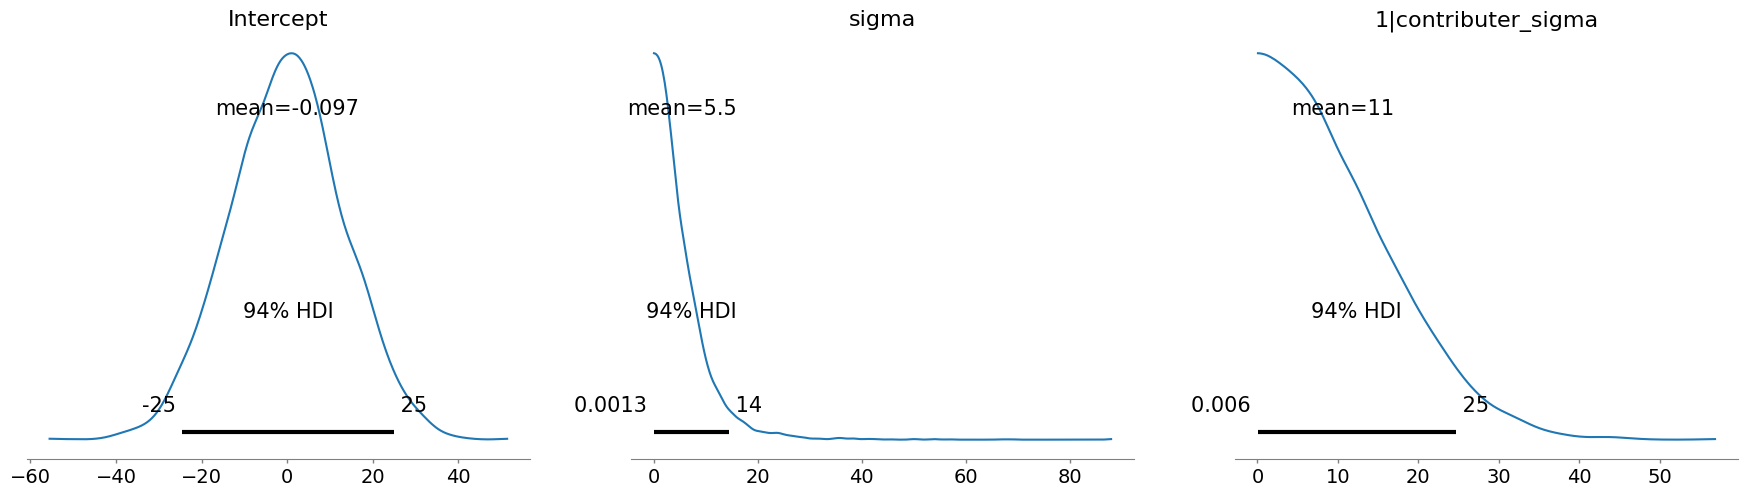

In [18]:
model.plot_priors()

array([[<Axes: title={'center': '1|contributer'}>,
        <Axes: title={'center': '1|contributer'}>],
       [<Axes: title={'center': '1|contributer_sigma'}>,
        <Axes: title={'center': '1|contributer_sigma'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

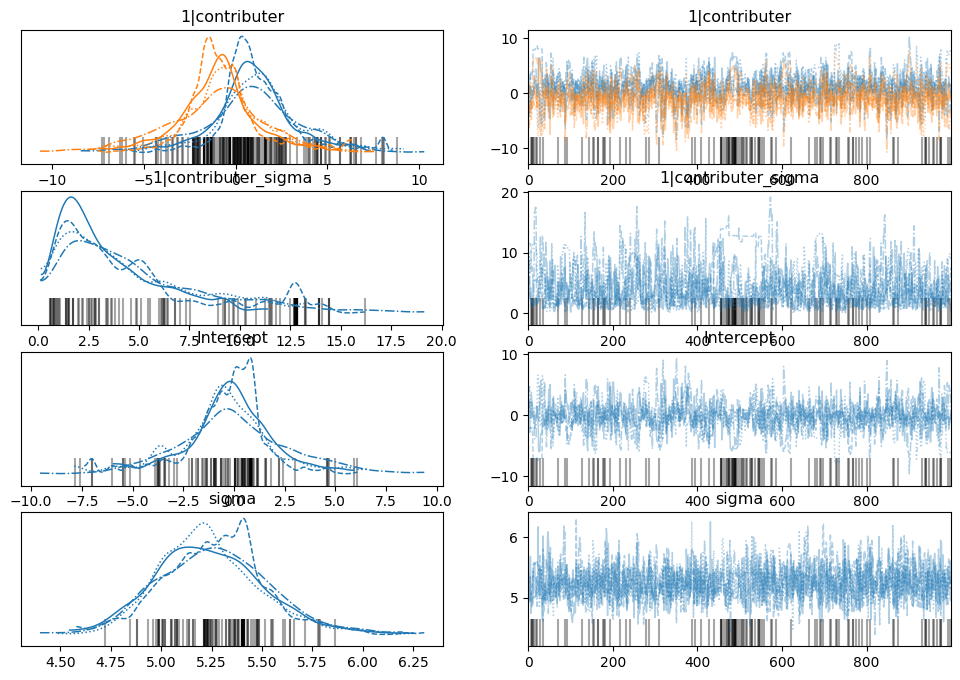

In [19]:
az.plot_trace(
    results,
    #var_names=["Intercept", "Time", "1|Pig", "Time|Pig", "Weight_sigma"],
    compact=True,
)

In [20]:
model

       Formula: value ~ 1 + (1|contributer)
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.0494, sigma: 13.2385)
        
        Group-level effects
            1|contributer ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 13.2385))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 5.2954)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

## PyMC

In [11]:
with pm.Model() as model0:
    contributer_data_idx = pm.ConstantData("contributer_data_idx", contributers0, dims="obs_id")
    #datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers)
    cons = pm.Normal("cons", mu=0, sigma = con_sigmas, shape=n_contributers)

    # expected value
    #y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx], dims = "obs_id") #one dimension for every datapoint
    y_hat = a_mu + cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = data0)

model0 works but is very slow. It takes 3min for 100 samples and two contributers, 5 mins for 200 samples.
* [creation of bins](https://www.pymc-labs.com/blog-posts/bayesian-inference-at-scale-running-ab-tests-with-millions-of-observations/)
* [JAX](https://github.com/martiningram/mcmc_runtime_comparison/blob/main/fit_pymc_blackjax.py) see [Blog Post](https://www.pymc-labs.com/blog-posts/pymc-stan-benchmark/)
* [BLAS Parallelization](https://discourse.pymc.io/t/parallelization-at-the-blas-level-when-sampling/13243/4)

### Blackjax

In [14]:
with model0:
    # No progress bar?
    hierarchical_trace = sampling_jax.sample_blackjax_nuts(
        chain_method="vectorized",)
        #idata_kwargs={'log_likelihood': False})

Running window adaptation


ValueError: too many values to unpack (expected 2)

### BLAS via pytensor
see [docs](https://pytensor.readthedocs.io/en/latest/tutorial/index.html)

pytensor is directly used by the backend...

In [21]:
import pytensor as pt

In [43]:
contributers_pt = pt.shared(contributers0)
data_pt = pt.shared(data0)

replacing data0 with the pt versions does not work. It will raise an error:

TypeError: Shared variable values can not be symbolic.

In [54]:
with pm.Model() as model_pt:
    contributer_data_idx = pm.ConstantData("contributer_data_idx", contributers0, dims="obs_id")
    #datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers)
    cons = pm.Normal("cons", mu=0, sigma = con_sigmas, shape=n_contributers)

    # expected value
    #y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx], dims = "obs_id") #one dimension for every datapoint
    y_hat = a_mu + cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = data0)
    
    f = model_pt.compile_logp().f
    # pt.dprint(f) # print the structure
    # m = pm.sample(cores=1, chains=1, draws=1000) # -> trigger the sampling

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


ValueError: Size length is incompatible with batched dimensions of parameter 0 Add.0:
len(size) = 1, len(batched dims Add.0) = 2. Size must be None or have length >= 2

In [26]:
assert n_samples<201

with model_pt:
    model_pt_prior = pm.sample_prior_predictive()
with model_pt:
    model_pt_trace = pm.sample(cores=15, chains=4, draws=1000)

Sampling: [a_mu, a_sigma, con_sigmas, cons, value]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_mu, a_sigma, con_sigmas, cons]


c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 315 seconds.
There were 262 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [27]:
az.summary(model_pt_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,-0.07,1.05,-2.04,1.80,0.04,0.03,625.69,1073.75,1.01
a_sigma,5.18,0.25,4.71,5.61,0.01,0.00,1213.28,1912.96,1.00
con_sigmas[0],1.20,1.03,0.05,2.97,0.04,0.03,335.95,153.82,1.01
con_sigmas[1],1.28,1.00,0.07,3.07,0.03,0.02,498.88,220.25,1.01
cons[0],0.81,1.06,-0.81,2.95,0.05,0.03,561.92,1261.65,1.01
cons[1],-0.94,1.06,-3.13,0.62,0.04,0.03,688.23,1295.88,1.01


array([[<Axes: title={'center': 'a_mu'}>,
        <Axes: title={'center': 'a_mu'}>],
       [<Axes: title={'center': 'a_sigma'}>,
        <Axes: title={'center': 'a_sigma'}>],
       [<Axes: title={'center': 'con_sigmas'}>,
        <Axes: title={'center': 'con_sigmas'}>],
       [<Axes: title={'center': 'cons'}>,
        <Axes: title={'center': 'cons'}>]], dtype=object)

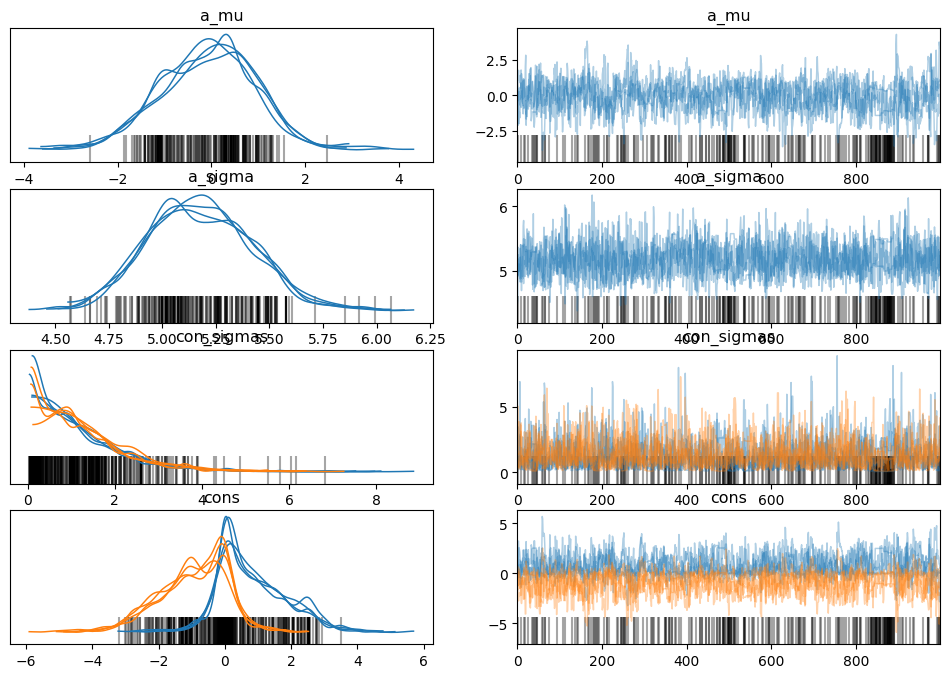

In [28]:
az.plot_trace(model_pt_trace,
              compact="true",
    chain_prop={"ls": "-"},)

### Nutpie

--> superfast :-)

In [56]:
contributers0.size

10000

In [57]:
data0.size

10000

In [63]:
data0.shape

(10000,)

In [59]:
set(list(contributers0))

{0, 1}

In [10]:
with pm.Model() as model_nutpie:
    contributer_data_idx = pm.ConstantData("contributer_data_idx", contributers0, dims="obs_id")
    #datam = pm.ConstantData("data_idx", data0, dims="obs_id")

    # Priors
    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10)
    a_sigma = pm.Exponential("a_sigma", 1)

    # contributions
    con_sigmas = pm.Exponential("con_sigmas", 1, shape=n_contributers)
    cons = pm.Normal("cons", mu=0, sigma = con_sigmas, shape=n_contributers)

    # expected value
    #y_hat = pm.Deterministic("y_hat", a_mu + cons[contributer_data_idx], dims = "obs_id") #one dimension for every datapoint
    y_hat = a_mu + cons[contributer_data_idx]
    # Data
    value = pm.Normal("value", 
                      mu=y_hat,
                      sigma = a_sigma,
                      observed = data0)

c:\Users\fuerf\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [23]:
compiled_model = nutpie.compile_pymc_model(model_nutpie)
trace_nutpie = nutpie.sample(
    compiled_model,
    tune=2000,
    draws=8000,
    chains=10,
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,10000,109,0.28,7
,10000,86,0.26,3
,10000,240,0.27,39
,10000,213,0.26,7
,10000,254,0.25,3
,10000,1000,0.24,31
,10000,739,0.21,63
,10000,104,0.25,39
,10000,266,0.21,31
,10000,394,0.26,27


In [24]:
az.summary(trace_nutpie, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,0.01,1.02,-1.61,1.71,0.02,0.01,2986.04,8758.85,1.01
a_sigma,5.18,0.04,5.11,5.24,0.00,0.00,9510.45,18037.82,1.00
a_sigma_log__,1.64,0.01,1.63,1.66,0.00,0.00,9510.45,18037.82,1.00
con_sigmas[0],1.27,1.00,0.01,2.98,0.01,0.01,1776.02,664.52,1.01
con_sigmas[1],1.28,1.03,0.01,3.09,0.03,0.02,754.26,305.48,1.02
con_sigmas_log__[0],-0.20,1.16,-2.53,1.60,0.04,0.04,1776.02,664.52,1.01
con_sigmas_log__[1],-0.19,1.16,-2.51,1.55,0.06,0.06,754.26,305.48,1.02
cons[0],0.98,1.02,-0.71,2.62,0.02,0.01,2982.29,8872.28,1.01
cons[1],-0.99,1.02,-2.69,0.64,0.02,0.01,3181.04,8977.16,1.00


array([[<Axes: title={'center': 'a_mu'}>,
        <Axes: title={'center': 'a_mu'}>],
       [<Axes: title={'center': 'a_sigma'}>,
        <Axes: title={'center': 'a_sigma'}>],
       [<Axes: title={'center': 'a_sigma_log__'}>,
        <Axes: title={'center': 'a_sigma_log__'}>],
       [<Axes: title={'center': 'con_sigmas'}>,
        <Axes: title={'center': 'con_sigmas'}>],
       [<Axes: title={'center': 'con_sigmas_log__'}>,
        <Axes: title={'center': 'con_sigmas_log__'}>],
       [<Axes: title={'center': 'cons'}>,
        <Axes: title={'center': 'cons'}>]], dtype=object)

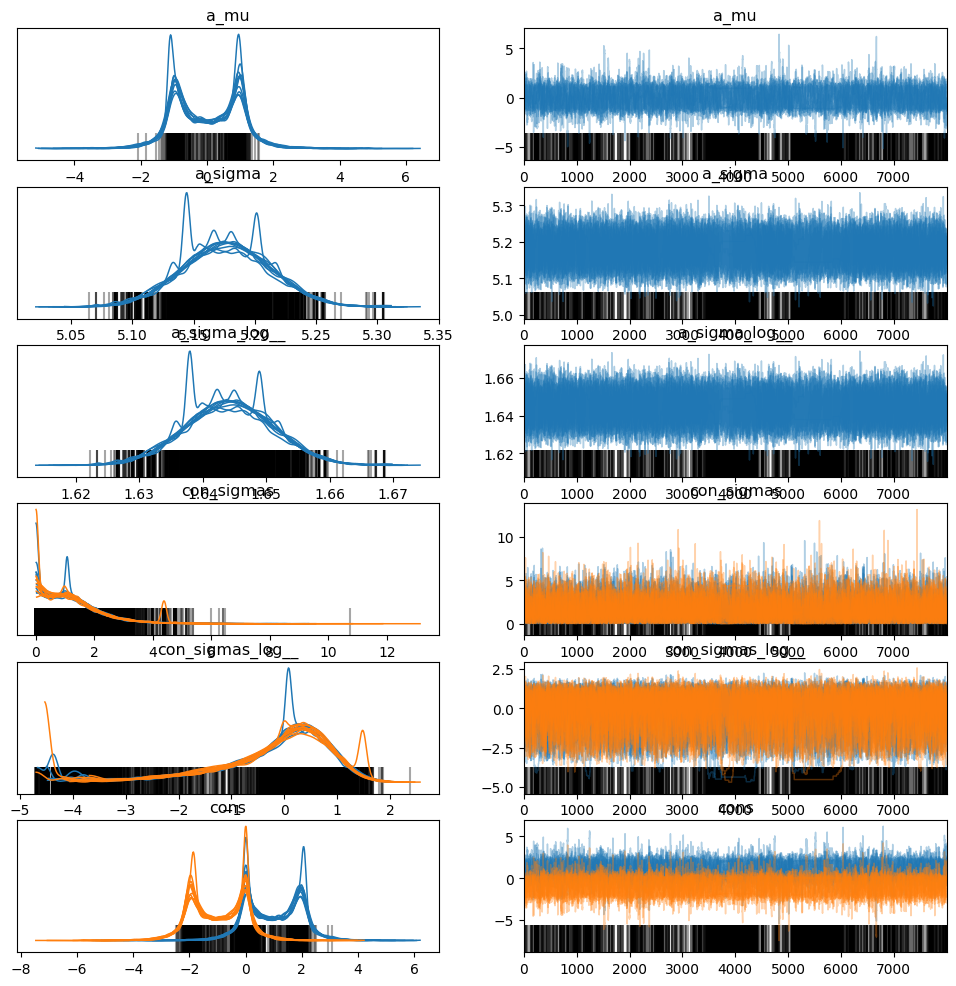

In [25]:
az.plot_trace(trace_nutpie,
              compact="true",
    chain_prop={"ls": "-"},)

In [26]:
help(nutpie.sample)

Help on function sample in module nutpie.sample:

sample(compiled_model: nutpie.sample.CompiledModel, *, draws: int = 1000, tune: int = 300, chains: int = 6, cores: Optional[int] = None, seed: Optional[int] = None, save_warmup: bool = True, progress_bar: bool = True, low_rank_modified_mass_matrix: bool = False, init_mean: Optional[numpy.ndarray] = None, return_raw_trace: bool = False, blocking: bool = True, progress_template: Optional[str] = None, progress_style: Optional[str] = None, progress_rate: int = 100, **kwargs) -> arviz.data.inference_data.InferenceData
    Sample the posterior distribution for a compiled model.

    Parameters
    ----------
    draws: int
        The number of draws after tuning in each chain.
    tune: int
        The number of tuning (warmup) draws in each chain.
    chains: int
        The number of chains to sample.
    cores: int
        The number of chains that should run in parallel.
    seed: int
        Seed for the randomness in sampling.
    num_